Aknowledgement:       

https://github.com/teyang-lau/Disaster_Tweet_Classification/blob/main/Tweet_Disaster_Classification.ipynb

In [ ]:
!pip install fastai==2.5.1 -q
!pip install nltk -q

In [53]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import nltk

nltk.download('punkt')
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from string import punctuation

COLORS = [sns.xkcd_rgb['medium blue'], sns.xkcd_rgb['pale red']]

# Read Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')
root = "/content/drive/MyDrive/deep_learning_salon/nlp_proj1_disaster_tweets"
os.chdir(root)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
analysis  data	documentation  models


In [5]:
train_df = pd.read_csv(os.path.join(root, 'data/raw_dataset/train.csv'))
valid_df = pd.read_csv(os.path.join(root, 'data/raw_dataset/test.csv'))
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Analysis

 ## Top Most Common Stopword

In [56]:
def count_top_stopwords(corpus, top_k=10):
  """
  Counting top stopwords in a corpus
  """
  stopwords_freq = defaultdict(lambda:0)
  for word in corpus:
    if word in stop: 
      stopwords_freq[word] += 1
  topwords = sorted(stopwords_freq.items(), key=lambda item: item[1], reverse=True)[:top_k] # get the top 10 stopwords
  x,y = zip(*topwords) # get key and values
  return x,y

Text(0.5, 1.0, 'Top Stopwords for  Disaster Tweets')

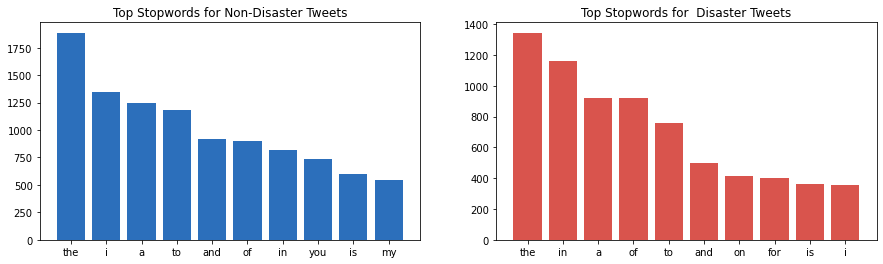

In [57]:
# Get all the word tokens in dataframe for Disaster and Non-Disaster
# Non-Disaster
corpus0 = [word.lower() for tweet in train_df[train_df.target == 0].text for word in word_tokenize(tweet)]
# Disaster
corpus1 = [word.lower() for tweet in train_df[train_df.target == 1].text for word in word_tokenize(tweet)]

# Counting top stopwords in a corpus
x0,y0 = count_top_stopwords(corpus0)
x1,y1 = count_top_stopwords(corpus1)


import seaborn as sns
# Plot bar plot of top stopwords for each class
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(x0,y0, color=COLORS[0])
plt.title('Top Stopwords for Non-Disaster Tweets')
plt.subplot(1,2,2)
plt.bar(x1,y1, color=COLORS[1])
plt.title('Top Stopwords for  Disaster Tweets')

## Most Common Punctuations

In [58]:
list('abst')

['a', 'b', 's', 't']

Text(0.5, 1.0, 'Top Punctuations for Disaster Tweets')

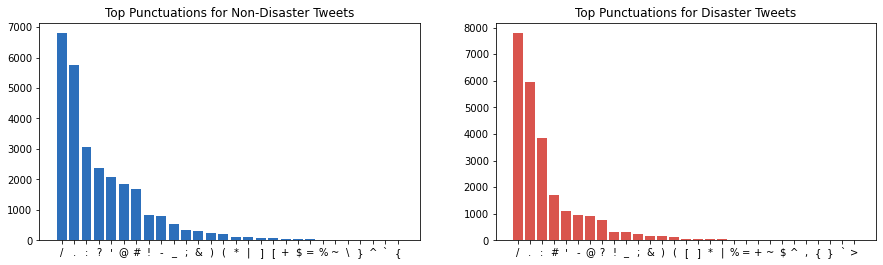

In [61]:
# Get all the punctuations in dataframe for Disaster and Non-Disaster
corpus0 = [] # Non-Disaster
for tweet in train_df[train_df.target == 0].text:
  corpus0.extend(list(tweet))
corpus0 = list(filter(lambda x: x in punctuation, corpus0)) 
corpus1 = [] # Disaster
for tweet in train_df[train_df.target == 1].text:
  corpus1.extend(list(tweet))
corpus1 = list(filter(lambda x: x in punctuation, corpus1)) 

from collections import Counter
x0,y0 = zip(*Counter(corpus0).most_common())
x1,y1 = zip(*Counter(corpus1).most_common())

# Plot bar plot of top punctuations for each class
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(x0,y0, color=COLORS[0])
plt.title('Top Punctuations for Non-Disaster Tweets')
plt.subplot(1,2,2)
plt.bar(x1,y1, color=COLORS[1])
plt.title('Top Punctuations for Disaster Tweets')

## Wordcloud for Hashtags

Text(0.5, 1.0, 'Disaster')

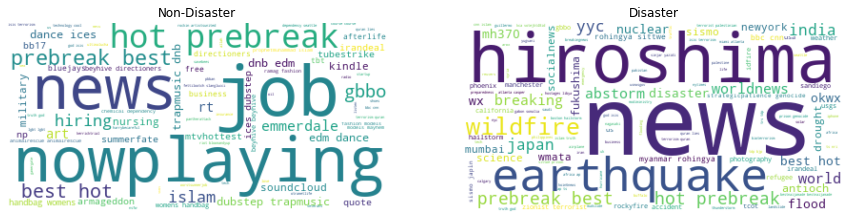

In [66]:
from wordcloud import WordCloud

def clean(word):
    for p in punctuation: word = word.replace(p, '')
    return word

def wc_hash(target):
    hashtag = [clean(w[1:].lower()) for tweet in train_df[train_df.target == target].text for w in tweet.split() if '#' in w and w[0] == '#']
    hashtag = ' '.join(hashtag)
    my_cloud = WordCloud(background_color='white', stopwords=stop).generate(hashtag)

    plt.subplot(1,2,target+1)
    plt.imshow(my_cloud, interpolation='bilinear') 
    plt.axis("off")
    return hashtag

plt.figure(figsize=(15,4))
hashtag_0 = wc_hash(0)
plt.title('Non-Disaster')
hashtag_1 = wc_hash(1)
plt.title('Disaster')

# Data pre-processing

In [106]:
tweets = train_df.copy()

In [125]:
# Function for 
def decontraction(phrase):
  """
  Expands most common contractions https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\b\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

def remove_punct(text):
    new_punct = re.sub('\ |\!|\?', '', punctuation)
    table=str.maketrans('','',new_punct)
    return text.translate(table)


tweets.text = [decontraction(tweet) for tweet in tweets.text]
tweets.text = tweets.text.apply(lambda x: remove_url(x))
tweets.text = tweets.text.apply(lambda x: remove_punct(x))
tweets.text = tweets.text.apply(lambda x: x.lower())

In [117]:
index = 80
print(train_df.text[index])
print(tweets.text[index])

mom: 'we didn't get home as fast as we wished' 
me: 'why is that?'
mom: 'there was an accident and some truck spilt mayonnaise all over ??????
mom we did not get home as fast as we wished me why is thatmom nothere was an accident and some truck spilt mayonnaise all over


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

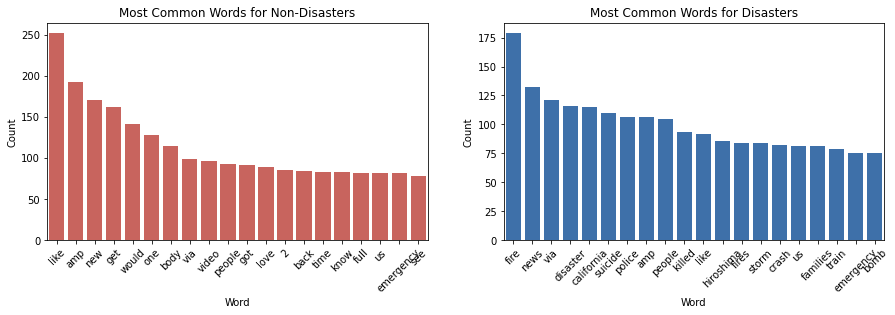

In [121]:
# Non-Disaster
corpus0 = [word.lower() for tweet in tweets[tweets.target == 0].text for word in word_tokenize(remove_url(tweet))]
corpus0 = list(filter(lambda x: x not in stop, corpus0)) # use filter to unselect stopwords

# Disaster
corpus1 = [word.lower() for tweet in tweets[tweets.target == 1].text for word in word_tokenize(remove_url(tweet))]
corpus1 = list(filter(lambda x: x not in stop, corpus1)) # use filter to unselect stopwords

# Create df for word counts to use sns plots
a = Counter(corpus0).most_common()
df0 = pd.DataFrame(a, columns=['Word','Count'])

a = Counter(corpus1).most_common()
df1 = pd.DataFrame(a, columns=['Word','Count'])

# Plot for Disaster and Non-Disaster
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
k_top = 20
sns.barplot(x='Word',y='Count',data=df0.head(k_top), color=COLORS[1]).set_title('Most Common Words for Non-Disasters')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.barplot(x='Word',y='Count',data=df1.head(k_top), color=COLORS[0]).set_title('Most Common Words for Disasters')
plt.xticks(rotation=45)

In [126]:
for i in range(100):
  print(tweets.text[i])

our deeds are the reason of this earthquake may allah forgive us all
forest fire near la ronge sask canada
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
13000 people receive wildfires evacuation orders in california
just got sent this photo from ruby alaska as smoke from wildfires pours into a school
rockyfire update california hwy 20 closed in both directions due to lake county fire cafire wildfires
flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas
i am on top of the hill and i can see a fire in the woods
there is an emergency evacuation happening now in the building across the street
i am afraid that the tornado is coming to our area
three people died from the heat wave so far
haha south tampa is getting flooded hah wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
raining flooding florida tampabay tampa 18 or 19 days i 

## Embedding

We will use the GloVe embeddings that were pre-trained on 2 billion tweets to create our feature matrix. First, we will create a dictionary that will contain words as keys and their corresponding embedding list at values. The length of the embedding for each word will be 200, as the GloVe embedding we are using was trained to have 200 dimensions. Refer to [here](https://github.com/stanfordnlp/GloVe) also for more details.

In [128]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('../input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

FileNotFoundError: ignored